In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 1. Data Pre-processing step

# a) Read Raisin_Dataset from Excel file using Pandas and display First 5 rows
raisin_df = pd.read_excel('/content/Raisin_Dataset.xlsx')  # Changed from read_csv to read_excel
print("First 5 rows of the dataset:")
print(raisin_df.head())
print("\nDataset shape:", raisin_df.shape)
print("\nDataset info:")
print(raisin_df.info())

First 5 rows of the dataset:
    Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  87524       442.246011       253.291155      0.819738       90546   
1  75166       406.690687       243.032436      0.801805       78789   
2  90856       442.267048       266.328318      0.798354       93717   
3  45928       286.540559       208.760042      0.684989       47336   
4  79408       352.190770       290.827533      0.564011       81463   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen  

Dataset shape: (900, 8)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   M

In [4]:

# b) Check the presence of Null Values/Missing Values
print("\nChecking for missing values:")
missing_values = raisin_df.isnull().sum()
print(missing_values)

# Handle missing values if present
if missing_values.any():
    print("\nHandling missing values...")
    # Option 1: Drop rows with missing values
    # raisin_df = raisin_df.dropna()

    # Option 2: Fill with mean for numerical columns
    for column in raisin_df.select_dtypes(include=[np.number]).columns:
        if raisin_df[column].isnull().any():
            raisin_df[column].fillna(raisin_df[column].mean(), inplace=True)

    print("Missing values handled.")
else:
    print("No missing values found.")



Checking for missing values:
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64
No missing values found.


In [5]:

# c) Convert the Class value into discrete: Kecimen as '0' and Besni raisin as '1' class
print("\nClass distribution before conversion:")
print(raisin_df['Class'].value_counts())

raisin_df['Class'] = raisin_df['Class'].map({'Kecimen': 0, 'Besni': 1})
print("\nClass distribution after conversion:")
print(raisin_df['Class'].value_counts())


Class distribution before conversion:
Class
Kecimen    450
Besni      450
Name: count, dtype: int64

Class distribution after conversion:
Class
0    450
1    450
Name: count, dtype: int64


In [6]:
# d) Check Feature importance using Chi-Square
X = raisin_df.drop('Class', axis=1)
y = raisin_df['Class']

print("\nFeature names:")
print(X.columns.tolist())

# Chi-square test for feature selection
chi_scores, p_values = chi2(X, y)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi_scores,
    'p_value': p_values
})

# Sort by Chi2 score
feature_importance_df = feature_importance_df.sort_values('Chi2_Score', ascending=False)
print("\nFeature importance (Chi-Square test):")
print(feature_importance_df)



Feature names:
['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']

Feature importance (Chi-Square test):
           Feature    Chi2_Score   p_value
4       ConvexArea  6.412753e+06  0.000000
0             Area  6.097822e+06  0.000000
6        Perimeter  2.563142e+04  0.000000
1  MajorAxisLength  1.272952e+04  0.000000
2  MinorAxisLength  2.234351e+03  0.000000
3     Eccentricity  1.804260e+00  0.179198
5           Extent  8.791728e-02  0.766842


In [7]:

# e) Discard the least important features using chi-square value
# Method 1: Keep features above median chi2 score
threshold = feature_importance_df['Chi2_Score'].median()
features_to_keep = feature_importance_df[feature_importance_df['Chi2_Score'] >= threshold]['Feature'].tolist()

# Alternative Method 2: Keep top N features (e.g., top 5)
# features_to_keep = feature_importance_df.head(5)['Feature'].tolist()

print(f"\nThreshold (median chi2 score): {threshold:.4f}")
print(f"Features to keep: {features_to_keep}")
print(f"Features discarded: {[f for f in X.columns if f not in features_to_keep]}")

# Select important features
X_selected = X[features_to_keep]
print(f"\nSelected features shape: {X_selected.shape}")



Threshold (median chi2 score): 12729.5190
Features to keep: ['ConvexArea', 'Area', 'Perimeter', 'MajorAxisLength']
Features discarded: ['MinorAxisLength', 'Eccentricity', 'Extent']

Selected features shape: (900, 4)


In [8]:


# 2. Split the dataset into 80% for training and rest 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train class distribution: {pd.Series(y_train).value_counts()}")
print(f"Test class distribution: {pd.Series(y_test).value_counts()}")


Train set shape: (720, 4)
Test set shape: (180, 4)
Train class distribution: Class
0    360
1    360
Name: count, dtype: int64
Test class distribution: Class
0    90
1    90
Name: count, dtype: int64


In [9]:
# 3. Train DT classifier using built-in function with default parameters
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

print("\nDecision Tree Classifier trained successfully!")
print(f"Tree depth: {dt_classifier.get_depth()}")
print(f"Number of leaves: {dt_classifier.get_n_leaves()}")



Decision Tree Classifier trained successfully!
Tree depth: 13
Number of leaves: 103


In [10]:
# 4. Evaluate the trained model using test set
# Make predictions
y_pred = dt_classifier.predict(X_test)

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

print(f"\nConfusion Matrix:")
print(conf_matrix)

print(f"\nPerformance Metrics:")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")

# Additional metrics breakdown
print(f"\nDetailed Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Kecimen', 'Besni']))



MODEL EVALUATION RESULTS

Confusion Matrix:
[[77 13]
 [21 69]]

Performance Metrics:
Accuracy:  0.8111 (81.11%)
Precision: 0.8415 (84.15%)
Recall:    0.7667 (76.67%)

Detailed Classification Report:
              precision    recall  f1-score   support

     Kecimen       0.79      0.86      0.82        90
       Besni       0.84      0.77      0.80        90

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180




Metrics Summary:
      Metric     Score
0   Accuracy  0.811111
1  Precision  0.841463
2     Recall  0.766667


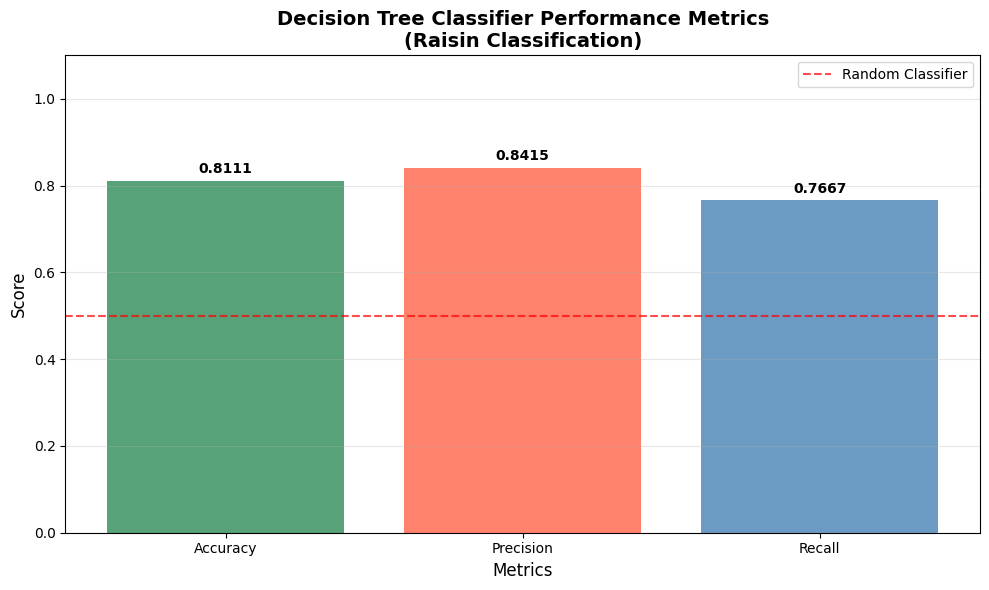

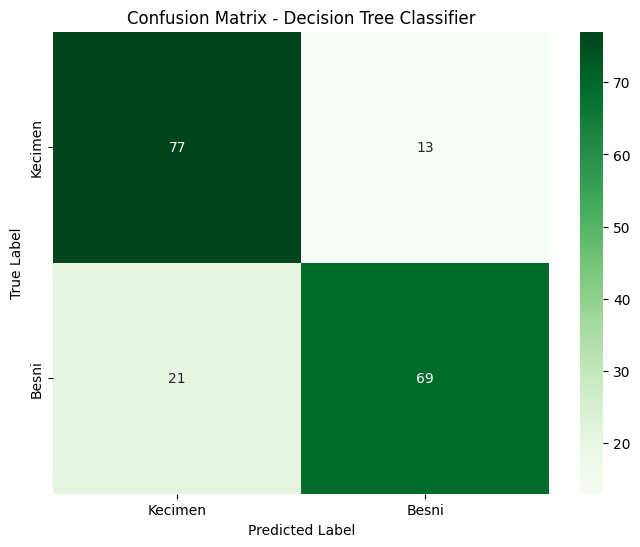


Feature Importance from Trained Decision Tree:
           Feature  Importance
3  MajorAxisLength    0.643987
2        Perimeter    0.147377
1             Area    0.121514
0       ConvexArea    0.087122

Results saved to 'raisin_classification_results.csv'
Processed dataset saved to 'processed_raisin_dataset.xlsx'


In [12]:

# 5. Compare the results using suitable chart
# Prepare data for visualization
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
}

metrics_df = pd.DataFrame(metrics_data)
print(f"\nMetrics Summary:")
print(metrics_df)

# Create visualization using matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df['Metric'], metrics_df['Score'],
               color=['#2E8B57', '#FF6347', '#4682B4'], alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.1)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.title('Decision Tree Classifier Performance Metrics\n(Raisin Classification)',
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add horizontal line at 0.5 for reference
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Classifier')
plt.legend()

plt.tight_layout()
plt.show()

# Additional visualization: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Kecimen', 'Besni'],
            yticklabels=['Kecimen', 'Besni'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

# Feature importance from the trained model
feature_importances = dt_classifier.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': features_to_keep,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance from Trained Decision Tree:")
print(feature_imp_df)

# Save results to CSV
results_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
})
results_summary.to_csv('raisin_classification_results.csv', index=False)
print(f"\nResults saved to 'raisin_classification_results.csv'")

# Optional: Save the processed dataset to Excel
raisin_df.to_excel('processed_raisin_dataset.xlsx', index=False)
print(f"Processed dataset saved to 'processed_raisin_dataset.xlsx'")
